# 게임의 인기도 분석 프로젝트

## 1. 문제 정의
* Task : Steam 플랫폼에서 게임의 인기여부 예측
 * 다양한 지표를 잡을 수 있으나, 여기선 긍정적 평가 비율이 높을수록 인기있다고 판단.
* Performance : 인기 / 비인기의 형태로 이진 분류
 * (긍정 / 전체평가)에 대한 비율을 매겨서 이를 지표로 삼음
* Experience : steamspy 사이트를 크롤링한 자료.
 * 해당 사이트에서 데이터를 제공하긴 하나, 자료형태로 제공하진 않으므로 자체적인 크롤링 과정이 필수.

## 2. 관련 데이터 수집


### 2-1. Data 크롤링
* 업로드 된 파일 중 data_collector 파일 참고.
* steamspy 사이트에 요청을하여서 1000개 게임에 대한 정보를 뽑아내는 코드. (기본값 : [0])
* request_appid의 인자로 [0, 1, 2]라는 값을 넣으면 총 3000개의 정보를 뽑아낼 수 있음
* data_collector 파일을 실행시키고 어느정도의 시간이 흐르면 steam_data.csv와 data_info.txt 파일이 생성.
 * data_info.txt - 해당 데이터를 크롤링 한 시점 저장
 * steam_data.csv - 사용 할 데이터 저장
 > 단, 데이터를 크롤링만 한 다음 특별한 정제 없이 자료화 하였으므로, 정제과정이 필요함!

### 2-2. Data check

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# 현재 분석 할 자료의 경우 사전에 크롤링하여서 구글드라이브에 저장해놓았음. (원본 데이터셋 참고)
!gdown --id "18W8JeGs5TkfUfy3g4kkSW9t4Vscfab6o"  # csv 파일
!gdown --id "10LUmuubAeErb1u8KJS7TO0tIye7KsWQq"  # txt 파일

Downloading...
From: https://drive.google.com/uc?id=18W8JeGs5TkfUfy3g4kkSW9t4Vscfab6o
To: /content/steam_data.csv
100% 1.57M/1.57M [00:00<00:00, 77.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=10LUmuubAeErb1u8KJS7TO0tIye7KsWQq
To: /content/date_info.txt
100% 34.0/34.0 [00:00<00:00, 30.3kB/s]


In [ ]:
steam_data = pd.read_csv("steam_data.csv", encoding='ISO-8859-1')
infile = open("date_info.txt", "r")
crawl_date = infile.readlines()
infile.close()

In [ ]:
# 데이터 크롤링 시점 확인.
print(crawl_date)

['Crawled Date : 2021-01-10 17:35:05']


In [ ]:
# 들고온 데이터 dataframe 형태로 확인.  (**미정제)
steam_data.head()

,appid,name,developer,publisher,score_rank,positive,negative,userscore,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu,languages,genre,tags
0,10,Counter-Strike,Valve,Valve,NaN,170096,4383,0,"10,000,000 .. 20,000,000",9964,1707,280,149,999,999,0,21522,"English, French, German, Italian, Spanish - Sp...",Action,"{'Action': 5335, 'FPS': 4745, 'Multiplayer': 3..."
1,20,Team Fortress Classic,Valve,Valve,NaN,4665,812,0,"2,000,000 .. 5,000,000",43,0,15,0,499,499,0,97,"English, French, German, Italian, Spanish - Sp...",Action,"{'Action': 738, 'FPS': 300, 'Multiplayer': 253..."
2,30,Day of Defeat,Valve,Valve,NaN,4545,496,0,"5,000,000 .. 10,000,000",510,0,11,0,499,499,0,149,"English, French, German, Italian, Spanish - Spain",Action,"{'FPS': 778, 'World War II': 244, 'Multiplayer..."
3,40,Deathmatch Classic,Valve,Valve,NaN,1662,355,0,"5,000,000 .. 10,000,000",1126,0,6,0,499,499,0,10,"English, French, German, Italian, Spanish - Sp...",Action,"{'Action': 626, 'FPS': 136, 'Classic': 104, 'M..."
4,50,Half-Life: Opposing Force,Gearbox Software,Valve,NaN,10068,527,0,"5,000,000 .. 10,000,000",743,0,48,0,499,499,0,184,"English, French, German, Korean",Action,"{'FPS': 871, 'Action': 312, 'Classic': 240, 'S..."


In [ ]:
steam_data.iloc[104]

appid                                                           6810
name                              Commandos: Beyond the Call of Duty
developer                                               Pyro Studios
publisher                                      Kalypso Media Digital
score_rank                                                       NaN
positive                                                         579
negative                                                          86
userscore                                                          0
owners                                          500,000 .. 1,000,000
average_forever                                                   11
average_2weeks                                                     0
median_forever                                                    14
median_2weeks                                                      0
price                                                            499
initialprice                      

* 데이터 설명
 * appid - 각 게임의 steam 플랫폼 상에서 고유 식별번호.
 * name - 게임 이름
 * developer - 개발자 / 개발회사
 * publisher - 배포업체
 * score rank - * 특정 경우에 대한 평점, 불필요정보.
 * positive - 유저들의 긍정적 평가 수
 * negative - 유저들의 부정적 평가 수
 * userscore - * 특정 경우에 대한 유저평점, 불필요정보.
 * owners - 현재 게임을 보유한 사람의 수 범위  (정제 필요.)
 * average forever - 게임 플레이 시간 평균, 전 기간 기준
 * average 2weeks - 게임 플레이 시간 평균, 최근 2주 기준
 * median forever - 게임 플레이 시간 중간값, 전 기간 기준
 * median 2weeks - 게임 플레이 시간 중간값, 최근 2주 기준
 * price - 게임의 원가, 999 => $9.99 로 해석.
 * initial price - 할인을 고려한 판매 가격
 * discount - 할인 가격
 * ccu - 동시접속자수의 고(高)점 (기준은 크롤링 전날 data)
 * languages - 지원 언어  (정제 필요.)
 * genre - 게임 장르 (정제 필요.)
 * tags - 게임에 매겨진 태그, (정제 필요.)

In [ ]:
steam_data.shape

(3000, 20)

## 3. Data 정제

### 3-1. 완결성 파악

#### 3-1-1. 결측치 파악

In [ ]:
# score_rank, userscore의 경우 col 삭제.
steam_data = steam_data.drop(["score_rank", "userscore"], axis=1)

In [ ]:
steam_data.isnull().sum()
# developer, publisher, genre의 경우 빠진 부분은 채워넣기.

appid               0
name                0
developer          17
publisher          18
positive            0
negative            0
owners              0
average_forever     0
average_2weeks      0
median_forever      0
median_2weeks       0
price               0
initialprice        0
discount            0
ccu                 0
languages           1
genre              25
tags                1
dtype: int64

In [ ]:
steam_data.head()

,appid,name,developer,publisher,positive,negative,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu,languages,genre,tags
0,10,Counter-Strike,Valve,Valve,170096,4383,"10,000,000 .. 20,000,000",9964,1707,280,149,999,999,0,21522,"English, French, German, Italian, Spanish - Sp...",Action,"{'Action': 5335, 'FPS': 4745, 'Multiplayer': 3..."
1,20,Team Fortress Classic,Valve,Valve,4665,812,"2,000,000 .. 5,000,000",43,0,15,0,499,499,0,97,"English, French, German, Italian, Spanish - Sp...",Action,"{'Action': 738, 'FPS': 300, 'Multiplayer': 253..."
2,30,Day of Defeat,Valve,Valve,4545,496,"5,000,000 .. 10,000,000",510,0,11,0,499,499,0,149,"English, French, German, Italian, Spanish - Spain",Action,"{'FPS': 778, 'World War II': 244, 'Multiplayer..."
3,40,Deathmatch Classic,Valve,Valve,1662,355,"5,000,000 .. 10,000,000",1126,0,6,0,499,499,0,10,"English, French, German, Italian, Spanish - Sp...",Action,"{'Action': 626, 'FPS': 136, 'Classic': 104, 'M..."
4,50,Half-Life: Opposing Force,Gearbox Software,Valve,10068,527,"5,000,000 .. 10,000,000",743,0,48,0,499,499,0,184,"English, French, German, Korean",Action,"{'FPS': 871, 'Action': 312, 'Classic': 240, 'S..."


In [ ]:
df_nan_cnt = steam_data.isnull().sum(1)
df_nan_index = df_nan_cnt[(df_nan_cnt > 0)]

steam_data.loc[df_nan_index.index]  # 결측치가 있는 데이터만 표현

,appid,name,developer,publisher,positive,negative,owners,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu,languages,genre,tags
166,11370,Nikopol: Secrets of the Immortals,NaN,Meridian4,180,142,"200,000 .. 500,000",1306,0,1307,0,499,499,0,1,"English, French, German, Italian, Spanish - Spain",NaN,"{'Point & Click': 174, 'Adventure': 168, 'Inve..."
218,17390,SPORE,Maxis??Electronic Arts,NaN,27801,2801,"1,000,000 .. 2,000,000",983,273,318,465,1999,1999,0,1547,"English, Czech, Danish, German, Spanish - Spai...","Action, Adventure, Casual, RPG, Simulation, St...","{'God Game': 1290, 'Casual': 1284, 'Cute': 128..."
221,17440,SPORE Creepy & Cute Parts Pack,Maxis??Electronic Arts,NaN,914,136,"500,000 .. 1,000,000",91,474,72,474,1999,1999,0,88,"English, Czech, Danish, German, Spanish - Spai...",Simulation,NaN
264,22340,Call of Cthulhu: Dark Corners of the Earth,Headfirst Productions,Bethesda Softworks,1635,734,"200,000 .. 500,000",245,0,310,0,499,499,0,13,"English, French, German",NaN,"{'Lovecraftian': 210, 'Horror': 210, 'First-Pe..."
469,71250,Sonic Adventure DX,SEGA,SEGA,6276,808,"200,000 .. 500,000",3619,4351,191,4351,799,799,0,143,"English, French, German, Japanese, Spanish - S...",NaN,"{'Platformer': 186, '3D Platformer': 156, 'Gre..."
545,200940,Sonic CD,Blit Software,SEGA,3282,374,"200,000 .. 500,000",2046,0,46,0,499,499,0,17,"English, French, German, Italian, Spanish - Spain",NaN,"{'Platformer': 251, 'Classic': 194, 'Great Sou..."
556,202530,Sonic the Hedgehog 4 - Episode I,SEGA,SEGA,820,1029,"200,000 .. 500,000",406,0,536,0,999,999,0,28,"English, German, French, Italian, Spanish - Sp...",NaN,"{'Platformer': 82, '2D': 41, 'Action': 31, 'Ad..."
657,214190,Minimum,NaN,"Atari, Cubed Productions LLC",2504,1683,"200,000 .. 500,000",143,0,194,0,0,0,0,0,English,Action,"{'Action': 188, 'Third-Person Shooter': 137, '..."
746,223850,3DMark,UL,UL,6501,548,"500,000 .. 1,000,000",2547,43,112,56,2999,2999,0,993,"English, German, Simplified Chinese, Russian, ...",NaN,"{'Benchmark': 232, 'Utilities': 144, 'Software..."
905,241930,Middle-earth: Shadow of Mordor,Monolith Productions,Warner Bros. Games,60943,5151,"2,000,000 .. 5,000,000",1073,92,739,105,1999,1999,0,1226,"English, French, Italian, German, Spanish - Sp...",NaN,"{'Open World': 1434, 'Action': 1360, 'Fantasy'..."


#### 3-1-2. 결측치 보완

In [ ]:
# developer나 publisher의 정보가 없는 경우 이 두개의 정보를 동일하게 갱신.
steam_data[["developer", "publisher"]] = steam_data[["developer", "publisher"]].fillna(method='ffill', axis=1)
steam_data[["developer", "publisher"]] = steam_data[["developer", "publisher"]].fillna(method='bfill', axis=1)

In [ ]:
steam_data[["developer", "publisher"]].loc[df_nan_index.index]

,developer,publisher
166,Meridian4,Meridian4
218,Maxis??Electronic Arts,Maxis??Electronic Arts
221,Maxis??Electronic Arts,Maxis??Electronic Arts
264,Headfirst Productions,Bethesda Softworks
469,SEGA,SEGA
545,Blit Software,SEGA
556,SEGA,SEGA
657,"Atari, Cubed Productions LLC","Atari, Cubed Productions LLC"
746,UL,UL
905,Monolith Productions,Warner Bros. Games


In [ ]:
# 1731 data의 경우 두개 모두 없어서 수기 기입.
pd.set_option('mode.chained_assignment', None) # warning 메세지 강제 무시용. 
steam_data['developer'][2417] = "spleen"
steam_data['publisher'][2417] = "spleen"
pd.set_option('mode.chained_assignment', 'warn')  # 다시 원래대로

In [ ]:
steam_data.isnull().sum()

appid               0
name                0
developer           0
publisher           0
positive            0
negative            0
owners              0
average_forever     0
average_2weeks      0
median_forever      0
median_2weeks       0
price               0
initialprice        0
discount            0
ccu                 0
languages           1
genre              25
tags                1
dtype: int64

In [ ]:
# genre, tag의 경우 수기로 직접 정보를 개입.
print(steam_data['genre'].loc[df_nan_index.index])

166                                                   NaN
218     Action, Adventure, Casual, RPG, Simulation, St...
221                                            Simulation
264                                                   NaN
469                                                   NaN
545                                                   NaN
556                                                   NaN
657                                                Action
746                                                   NaN
905                                                   NaN
907                                                   NaN
917                                                   NaN
918                                                   NaN
954                                                   NaN
959                                                   NaN
966                                    Action, Indie, RPG
988                                                   NaN
1023          

In [ ]:
pd.set_option('mode.chained_assignment', None) # warning 메세지 강제 무시용. 
# 정보 기입. (편의상 바로 dataframe에 수정하였음.)
steam_data['languages'][1400] = "English, French, German"
steam_data['genre'][166] = "Adventure, Indie"
steam_data['genre'][264] = "Survival, Horror"
steam_data['genre'][469] = "Platform, Action, Adventure"
steam_data['genre'][545] = "Platform, Action, Adventure"
steam_data['genre'][556] = "Platform, Action, Adventure"
steam_data['genre'][746] = "Utilities"
steam_data['genre'][905] = "Action, Adventure"
steam_data['genre'][907] = "Action, Adventure"
steam_data['genre'][917] = "RPG"
steam_data['genre'][918] = "Action"
steam_data['genre'][954] = "Action, Adventure"
steam_data['genre'][959] = "Action, Adventure"
steam_data['genre'][988] = "Utilities"
steam_data['genre'][1023] = "Action, Casual, Indie, Simulation"
steam_data['genre'][1027] = "RPG, Strategy"
steam_data['genre'][1028] = "RPG"
steam_data['genre'][1573] = "Utilities"
steam_data['genre'][1580] = "Adventure, Indie, Strategy"
steam_data['genre'][1788] = "Action, Adventure, Indie, RPG"
steam_data['genre'][1826] = "Game engine"
steam_data['genre'][2504] = "Action"
steam_data['genre'][2637] = "Action"
steam_data['genre'][2646] = "Adventure, Simulation, Sports"
steam_data['genre'][2743] = "RPG, Adventure"
steam_data['genre'][2991] = "Action"
steam_data['tags'][221] = "{'Action':441, 'Zombies':424, 'Co-op':403, 'Third-Person Shooter':316, 'Horror':288, 'Co-Op Campaign':275, 'Online Co-Op':260, 'Adventure':235, 'Third Person':177, 'Survival Horror':170, 'Multiplayer':165, 'Shooter':163, 'Singleplayer':150, 'Local Co-Op':102, 'Female Protagonist':102, 'Survival':94, 'Quick-Time Events':90, 'Gore':88, 'Atmospheric':51, '3D Vision':48}"

In [ ]:
pd.set_option('mode.chained_assignment', 'warn')  # 다시 원래대로
print(steam_data['genre'].loc[df_nan_index.index])

166                                      Adventure, Indie
218     Action, Adventure, Casual, RPG, Simulation, St...
221                                            Simulation
264                                      Survival, Horror
469                           Platform, Action, Adventure
545                           Platform, Action, Adventure
556                           Platform, Action, Adventure
657                                                Action
746                                             Utilities
905                                     Action, Adventure
907                                     Action, Adventure
917                                                   RPG
918                                                Action
954                                     Action, Adventure
959                                     Action, Adventure
966                                    Action, Indie, RPG
988                                             Utilities
1023          

In [ ]:
steam_data.isnull().sum()  # 일단 NaN 값이 없는 Data 완성.

appid              0
name               0
developer          0
publisher          0
positive           0
negative           0
owners             0
average_forever    0
average_2weeks     0
median_forever     0
median_2weeks      0
price              0
initialprice       0
discount           0
ccu                0
languages          0
genre              0
tags               0
dtype: int64

### 3-2. 데이터 확인 및 정제

In [ ]:
from collections import Counter

In [ ]:
steam_data.info()
# object로 구성 된 column을 다른 형태로 분해해야 한다.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   appid            3000 non-null   int64 
 1   name             3000 non-null   object
 2   developer        3000 non-null   object
 3   publisher        3000 non-null   object
 4   positive         3000 non-null   int64 
 5   negative         3000 non-null   int64 
 6   owners           3000 non-null   object
 7   average_forever  3000 non-null   int64 
 8   average_2weeks   3000 non-null   int64 
 9   median_forever   3000 non-null   int64 
 10  median_2weeks    3000 non-null   int64 
 11  price            3000 non-null   int64 
 12  initialprice     3000 non-null   int64 
 13  discount         3000 non-null   int64 
 14  ccu              3000 non-null   int64 
 15  languages        3000 non-null   object
 16  genre            3000 non-null   object
 17  tags             3000 non-null   

#### 3-2-1. y data 생성

##### 3-2-1-1. 표본 이상치 제거

In [ ]:
full_rate = steam_data['positive'] + steam_data['negative']

In [ ]:
full_rate.describe()

count    3.000000e+03
mean     1.876761e+04
std      1.140006e+05
min      0.000000e+00
25%      1.668500e+03
50%      4.276500e+03
75%      1.165725e+04
max      5.183728e+06
dtype: float64

In [ ]:
# 평가가 1000명 미만인 경우는 데이터 삭제.
full_rate.loc[full_rate < 1000].shape

(480,)

In [ ]:
# 평가가 1000명 미만인 게임의 index.
full_rate.loc[full_rate < 1000]

28      367
29      737
32      486
42      958
46      140
       ... 
2993      7
2994      5
2995      7
2996    549
2998      1
Length: 480, dtype: int64

In [ ]:
steam_data = steam_data.drop(full_rate.loc[full_rate < 1000].index, axis=0)

In [ ]:
steam_data.shape

(2520, 18)

##### 3-2-1-2. y 데이터 구축

In [ ]:
pos_rate = steam_data['positive']*100 / (steam_data['positive'] + steam_data['negative'])
pos_rate.isnull().sum()

0

In [ ]:
pos_rate = pos_rate.astype(int)
pos_rate  # 정수 형태로 바꾼 긍정 평가 지수.

0       97
1       85
2       90
3       82
4       95
        ..
2987    90
2989    82
2990    81
2997    95
2999    93
Length: 2520, dtype: int64

In [ ]:
pos_rate.describe()

count    2520.000000
mean       81.681746
std        13.142435
min        16.000000
25%        76.000000
50%        85.000000
75%        91.000000
max        99.000000
dtype: float64

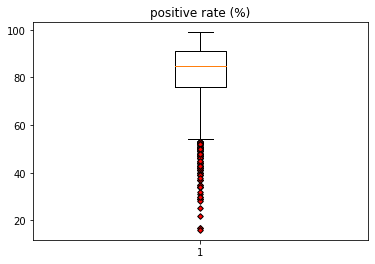

In [ ]:
plt.boxplot(pos_rate, flierprops=dict(marker='D', markersize=4, markerfacecolor='r'))
plt.title("positive rate (%)")
plt.show()

In [ ]:
outlier_indices = []

Q1 = np.percentile(pos_rate,25) 
Q3 = np.percentile(pos_rate,75)
IQR = Q3 - Q1
outlier_step = IQR * 1.5
outlier_list_col = pos_rate[(pos_rate < Q1 - outlier_step) | (pos_rate > Q3 + outlier_step)].index #filter
outlier_list_col

Int64Index([  63,  198,  213,  369,  406,  408,  416,  527,  556,  617,
            ...
            2816, 2838, 2840, 2858, 2871, 2884, 2902, 2914, 2935, 2979],
           dtype='int64', length=123)

In [ ]:
pos_rate = pos_rate.drop(outlier_list_col)
steam_data = steam_data.drop(outlier_list_col)
print(pos_rate.shape, steam_data.shape)   # y의 이상치 제거

(2397,) (2397, 18)


In [ ]:
# 긍정 평가가 85% 이상인 게임들이 대중들에게 인기가 있다고 가정. 값 치환.
popular = pd.Series([ 1 if val >= 85 else 0 for val in pos_rate ], index=pos_rate.index)
popular.value_counts()

1    1317
0    1080
dtype: int64

In [ ]:
# pos, neg 데이터는 필요 없으므로 삭제.
steam_data = steam_data.drop(["positive", "negative"], axis=1)
steam_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2397 entries, 0 to 2999
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   appid            2397 non-null   int64 
 1   name             2397 non-null   object
 2   developer        2397 non-null   object
 3   publisher        2397 non-null   object
 4   owners           2397 non-null   object
 5   average_forever  2397 non-null   int64 
 6   average_2weeks   2397 non-null   int64 
 7   median_forever   2397 non-null   int64 
 8   median_2weeks    2397 non-null   int64 
 9   price            2397 non-null   int64 
 10  initialprice     2397 non-null   int64 
 11  discount         2397 non-null   int64 
 12  ccu              2397 non-null   int64 
 13  languages        2397 non-null   object
 14  genre            2397 non-null   object
 15  tags             2397 non-null   object
dtypes: int64(9), object(7)
memory usage: 318.4+ KB


#### 3-2-2. 문자 데이터 처리

##### 3-2-2-1. owners 정보를 class별로 치환

In [ ]:
Counter(steam_data['owners'])  # 정보 확인

Counter({'0 .. 20,000': 1,
         '1,000,000 .. 2,000,000': 373,
         '10,000,000 .. 20,000,000': 28,
         '100,000 .. 200,000': 35,
         '100,000,000 .. 200,000,000': 1,
         '2,000,000 .. 5,000,000': 252,
         '20,000 .. 50,000': 8,
         '20,000,000 .. 50,000,000': 9,
         '200,000 .. 500,000': 1028,
         '5,000,000 .. 10,000,000': 63,
         '50,000 .. 100,000': 17,
         '50,000,000 .. 100,000,000': 2,
         '500,000 .. 1,000,000': 580})

In [ ]:
owners_label = {"0 .. 20,000" : 0,
                "20,000 .. 50,000" : 0,
                "50,000 .. 100,000" : 0,
                "100,000 .. 200,000" : 1,
                "200,000 .. 500,000" : 1,
                "500,000 .. 1,000,000" : 1,
                "1,000,000 .. 2,000,000" : 2,
                "2,000,000 .. 5,000,000" : 2,
                "5,000,000 .. 10,000,000" : 2,
                "10,000,000 .. 20,000,000" : 3,
                "20,000,000 .. 50,000,000" : 3,
                "50,000,000 .. 100,000,000" : 3,
                "100,000,000 .. 200,000,000" : 4,
                "200,000,000 .. 500,000,000" : 4,
                "500,000,000 .. 1,000,000,000" : 4
                }
print(owners_label)
# class 0 ) 0 ~ 100,000
# class 1 ) 100,000 ~ 1,000,000
# class 2 ) 1,000,000 ~ 10,000,000
# class 3 ) 10,000,000 ~ 100,000,000
# class 4 ) 100,000,000 ~ 1,000,000,000

{'0 .. 20,000': 0, '20,000 .. 50,000': 0, '50,000 .. 100,000': 0, '100,000 .. 200,000': 1, '200,000 .. 500,000': 1, '500,000 .. 1,000,000': 1, '1,000,000 .. 2,000,000': 2, '2,000,000 .. 5,000,000': 2, '5,000,000 .. 10,000,000': 2, '10,000,000 .. 20,000,000': 3, '20,000,000 .. 50,000,000': 3, '50,000,000 .. 100,000,000': 3, '100,000,000 .. 200,000,000': 4, '200,000,000 .. 500,000,000': 4, '500,000,000 .. 1,000,000,000': 4}


In [ ]:
steam_data = steam_data.replace({'owners' : owners_label})
steam_data = steam_data.rename(columns={'owners' : 'owner_class'})

In [ ]:
steam_data['owner_class'].value_counts().sort_index()

0      26
1    1643
2     688
3      39
4       1
Name: owner_class, dtype: int64

##### 3-2-2-2. languages 정보에서 지원 언어 개수를 추출

In [ ]:
print(steam_data['languages'][0])  # 정보 확인
print(steam_data['languages'][2643])

English, French, German, Italian, Spanish - Spain, Simplified Chinese, Traditional Chinese, Korean
English


In [ ]:
# 지원 언어 개수의 경우 해당 string에서 , 개수 +1개를 하면 된다고 추측 가능.
print( steam_data['languages'][0].count(',')+1 )
print( steam_data['languages'][2643].count(',')+1 )

8
1


In [ ]:
steam_data['language_count'] = steam_data['languages'].apply(lambda x: x.count(',')+1)

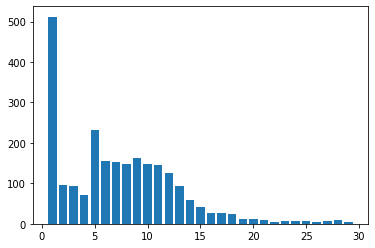

In [ ]:
plt.bar(steam_data['language_count'].value_counts().index, steam_data['language_count'].value_counts())
plt.show()

In [ ]:
# 추가 check, 단일 언어 중에서 높은 비율만 확인.
steam_data['languages'][steam_data['language_count']==1].value_counts()

English               510
Simplified Chinese      2
Name: languages, dtype: int64

##### 3-2-2-3. genre 및 tags 정보를 분해

In [ ]:
genre_tag = set()
genre_list = []

In [ ]:
# 우선 genre index에 대해.
for val in steam_data['genre']:
  one_split = val.replace("&", "n").lower().split(", ")
  genre_list.append(one_split)
  for tag in one_split:
    genre_tag.add(tag)
print(genre_tag)  # 전체 장르 태그
print(genre_list[30:40])  # 특정 태그

{'sexual content', 'sports', 'audio production', 'simulation', 'adventure', 'animation n modeling', 'utilities', 'platform', 'gore', 'violent', 'casual', 'nudity', 'photo editing', 'racing', 'design n illustration', 'action', 'early access', 'software training', 'game engine', 'massively multiplayer', 'horror', 'indie', 'free to play', 'web publishing', 'video production', 'rpg', 'survival', 'education', 'game development', 'strategy'}
[['rpg'], ['animation n modeling', 'video production'], ['strategy'], ['rpg'], ['action', 'rpg'], ['action'], ['action'], ['action'], ['action'], ['action']]


In [ ]:
from ast import literal_eval  # 문자열을 딕셔너리로 변환
index_cnt = 0
for val in steam_data['tags']:
  one_split = list(literal_eval(val.replace("&", "n").lower()).keys())
  genre_list[index_cnt] = genre_list[index_cnt] + one_split
  for tag in one_split:
    genre_tag.add(tag)
  index_cnt += 1
print(genre_tag)  # 전체 장르 태그
print(genre_list[30:40])  # 특정 태그

{'trading card game', 'artificial intelligence', 'clicker', 'transportation', 'vr only', 'bikes', 'martial arts', 'lego', 'sci-fi', 'deckbuilding', 'skateboarding', 'tutorial', 'massively multiplayer', 'multiple endings', 'voice control', 'naval', 'mars', 'stylized', 'education', 'third-person shooter', 'puzzle', 'strategy', 'on-rails shooter', 'memes', 'snow', 'anime', 'management', 'boxing', 'family friendly', 'remake', 'city builder', 'gore', 'side scroller', 'collectathon', 'offroad', 'alternate history', 'design n illustration', 'blood', 'tanks', 'immersive', 'crpg', 'atv', 'vr', 'card game', 'science', 'game development', 'software', 'crime', 'solitaire', 'cute', 'roguelike deckbuilder', 'bullet time', 'cinematic', 'wrestling', 'electronic music', 'epic', 'automation', 'real-time with pause', 'benchmark', 'choose your own adventure', 'lore-rich', 'bmx', 'split screen', 'character customization', 'dark comedy', 'software training', 'life sim', 'fishing', 'traditional roguelike', '

In [ ]:
# 전체 장르 태그만 재정리.
cnt = 1
for v in sorted(list(genre_tag)):
  print('"'+v+'"', end=',    ')
  if cnt%8 == 0: print()
  cnt += 1

"1980s",    "1990's",    "2.5d",    "2d",    "2d fighter",    "2d platformer",    "360 video",    "3d",    
"3d fighter",    "3d platformer",    "3d vision",    "4 player local",    "4x",    "6dof",    "abstract",    "action",    
"action roguelike",    "action rpg",    "action rts",    "action-adventure",    "addictive",    "adventure",    "agriculture",    "aliens",    
"alternate history",    "ambient",    "america",    "animation n modeling",    "anime",    "arcade",    "archery",    "arena shooter",    
"artificial intelligence",    "assassin",    "asymmetric vr",    "asynchronous multiplayer",    "atmospheric",    "atv",    "audio production",    "auto battler",    
"automation",    "automobile sim",    "base-building",    "based on a novel",    "basketball",    "battle royale",    "beat 'em up",    "beautiful",    
"benchmark",    "bikes",    "blood",    "bmx",    "board game",    "bowling",    "boxing",    "building",    
"bullet hell",    "bullet time",    "capitalism",    "ca

In [ ]:
df_isdata = pd.DataFrame(index=pos_rate.index)  # 특정 태그로 분류되어 있는지 여부 판단. 1은 True, 0는 False를 의미.
for tag in genre_tag:
  df_isdata["is_"+tag.replace(" ", "_")] = [1 if tag in lists else 0 for lists in genre_list]

In [ ]:
df_isdata_check = pd.DataFrame(df_isdata.sum(), columns=['counts'])

df_isdata_check['rate'] = df_isdata_check['counts'] / (popular.count())
min_per = 0.05 # 전체 게임의 min_per*100 % 비중 이하 태그
df_isdata_check.loc[df_isdata_check['rate'] <= min_per]  # 희소 데이터만 확인.

,counts,rate
is_trading_card_game,23,0.009595
is_artificial_intelligence,3,0.001252
is_clicker,47,0.019608
is_transportation,8,0.003338
is_vr_only,19,0.007927
...,...,...
is_skiing,2,0.000834
is_tactical_rpg,30,0.012516
is_dinosaurs,18,0.007509
is_cats,13,0.005423


In [ ]:
# 희소 태그에 대해선 삭제.
df_isdata = df_isdata.drop(list(df_isdata_check[df_isdata_check['rate'] <= min_per].index), axis=1)
df_isdata

,is_sci-fi,is_massively_multiplayer,is_third-person_shooter,is_puzzle,is_strategy,is_memes,is_anime,is_management,is_family_friendly,is_gore,is_side_scroller,is_cute,is_character_customization,is_military,is_first-person,is_survival_horror,is_singleplayer,is_dark,is_fast-paced,is_realistic,is_zombies,is_team-based,is_choices_matter,is_controller,is_historical,is_stealth,is_indie,is_fps,is_2d,is_third_person,is_funny,is_story_rich,is_mature,is_female_protagonist,is_moddable,is_pixel_graphics,is_building,is_early_access,is_hack_and_slash,is_replay_value,...,is_classic,is_survival,is_atmospheric,is_post-apocalyptic,is_space,is_great_soundtrack,is_arcade,is_crafting,is_rpg,is_pvp,is_adventure,is_shooter,is_physics,is_fantasy,is_horror,is_medieval,is_sandbox,is_competitive,is_sexual_content,is_short,is_exploration,is_point_n_click,is_action_rpg,is_online_co-op,is_turn-based_strategy,is_multiplayer,is_turn-based,is_open_world,is_psychological_horror,is_co-op,is_comedy,is_platformer,is_local_multiplayer,is_nudity,is_retro,is_free_to_play,is_tactical,is_casual,is_local_co-op,is_action
0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1
3,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
4,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2987,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0
2989,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1
2990,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1
2997,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0


In [ ]:
steam_data = steam_data.join(df_isdata)
steam_data.head()

,appid,name,developer,publisher,owner_class,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu,languages,genre,tags,language_count,is_sci-fi,is_massively_multiplayer,is_third-person_shooter,is_puzzle,is_strategy,is_memes,is_anime,is_management,is_family_friendly,is_gore,is_side_scroller,is_cute,is_character_customization,is_military,is_first-person,is_survival_horror,is_singleplayer,is_dark,is_fast-paced,is_realistic,is_zombies,is_team-based,is_choices_matter,...,is_classic,is_survival,is_atmospheric,is_post-apocalyptic,is_space,is_great_soundtrack,is_arcade,is_crafting,is_rpg,is_pvp,is_adventure,is_shooter,is_physics,is_fantasy,is_horror,is_medieval,is_sandbox,is_competitive,is_sexual_content,is_short,is_exploration,is_point_n_click,is_action_rpg,is_online_co-op,is_turn-based_strategy,is_multiplayer,is_turn-based,is_open_world,is_psychological_horror,is_co-op,is_comedy,is_platformer,is_local_multiplayer,is_nudity,is_retro,is_free_to_play,is_tactical,is_casual,is_local_co-op,is_action
0,10,Counter-Strike,Valve,Valve,3,9964,1707,280,149,999,999,0,21522,"English, French, German, Italian, Spanish - Sp...",Action,"{'Action': 5335, 'FPS': 4745, 'Multiplayer': 3...",8,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,...,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
1,20,Team Fortress Classic,Valve,Valve,2,43,0,15,0,499,499,0,97,"English, French, German, Italian, Spanish - Sp...",Action,"{'Action': 738, 'FPS': 300, 'Multiplayer': 253...",9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
2,30,Day of Defeat,Valve,Valve,2,510,0,11,0,499,499,0,149,"English, French, German, Italian, Spanish - Spain",Action,"{'FPS': 778, 'World War II': 244, 'Multiplayer...",5,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1
3,40,Deathmatch Classic,Valve,Valve,2,1126,0,6,0,499,499,0,10,"English, French, German, Italian, Spanish - Sp...",Action,"{'Action': 626, 'FPS': 136, 'Classic': 104, 'M...",9,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
4,50,Half-Life: Opposing Force,Gearbox Software,Valve,2,743,0,48,0,499,499,0,184,"English, French, German, Korean",Action,"{'FPS': 871, 'Action': 312, 'Classic': 240, 'S...",4,1,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,...,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1


##### 3-2-3. 이상치 처리 및 불필요한 행 제거

In [ ]:
sample = steam_data.drop(["appid", "name", "developer", "publisher", "genre", "tags", "languages"], axis=1)
sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2397 entries, 0 to 2999
Data columns (total 98 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   owner_class                 2397 non-null   int64
 1   average_forever             2397 non-null   int64
 2   average_2weeks              2397 non-null   int64
 3   median_forever              2397 non-null   int64
 4   median_2weeks               2397 non-null   int64
 5   price                       2397 non-null   int64
 6   initialprice                2397 non-null   int64
 7   discount                    2397 non-null   int64
 8   ccu                         2397 non-null   int64
 9   language_count              2397 non-null   int64
 10  is_sci-fi                   2397 non-null   int64
 11  is_massively_multiplayer    2397 non-null   int64
 12  is_third-person_shooter     2397 non-null   int64
 13  is_puzzle                   2397 non-null   int64
 14  is_strat

In [ ]:
# outlier 찾아내기
def detect_outliers(df,features):
  outlier_indices = []
  for c in features:
    Q1 = np.percentile(df[c],25)
    Q3 = np.percentile(df[c],75)
    IQR = Q3 - Q1 
    outlier_step = IQR * 1.5 
    outlier_list_col = df[(df[c] < Q1 - outlier_step) | (df[c] > Q3 + outlier_step)].index #filter
    outlier_indices.extend(outlier_list_col)
  outlier_indices = Counter(outlier_indices)
  multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2) 
  return multiple_outliers

In [ ]:
sample.loc[detect_outliers(sample,["average_forever", "average_2weeks", "median_forever", "median_2weeks", "price", "initialprice", "ccu"])]
# 조금 이상이 있다 판단되는 값을 뽑아내기.

,owner_class,average_forever,average_2weeks,median_forever,median_2weeks,price,initialprice,discount,ccu,language_count,is_sci-fi,is_massively_multiplayer,is_third-person_shooter,is_puzzle,is_strategy,is_memes,is_anime,is_management,is_family_friendly,is_gore,is_side_scroller,is_cute,is_character_customization,is_military,is_first-person,is_survival_horror,is_singleplayer,is_dark,is_fast-paced,is_realistic,is_zombies,is_team-based,is_choices_matter,is_controller,is_historical,is_stealth,is_indie,is_fps,is_2d,is_third_person,...,is_classic,is_survival,is_atmospheric,is_post-apocalyptic,is_space,is_great_soundtrack,is_arcade,is_crafting,is_rpg,is_pvp,is_adventure,is_shooter,is_physics,is_fantasy,is_horror,is_medieval,is_sandbox,is_competitive,is_sexual_content,is_short,is_exploration,is_point_n_click,is_action_rpg,is_online_co-op,is_turn-based_strategy,is_multiplayer,is_turn-based,is_open_world,is_psychological_horror,is_co-op,is_comedy,is_platformer,is_local_multiplayer,is_nudity,is_retro,is_free_to_play,is_tactical,is_casual,is_local_co-op,is_action
0,3,9964,1707,280,149,999,999,0,21522,8,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
10,2,7150,172,630,123,999,999,0,7877,12,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,...,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
19,3,8851,1799,360,458,0,0,0,93990,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,1,0,0,0,0,1,1,0,0,1
22,3,35652,1533,990,791,0,0,0,613177,26,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1
25,4,26530,934,6314,353,0,0,0,1042244,28,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1702,1,1873,55,473,55,5999,5999,0,1631,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2328,1,543,0,546,0,5999,5999,0,1757,11,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1
2528,2,1246,0,1092,0,5999,5999,0,1632,11,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1
2579,1,1179,0,1179,0,5999,5999,0,1917,8,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0


In [ ]:
# 이상치 삭제 (col 지우기)
detect = detect_outliers(sample, ["average_forever", "average_2weeks", "median_forever", "median_2weeks", "price", "initialprice", "ccu"])
detect[0: 10]

[0, 10, 19, 22, 25, 34, 80, 85, 134, 139]

In [ ]:
sample = sample.drop( detect )
popular = popular.drop( detect )

## 4. 학습을 위한 Data 분리

In [ ]:
# 사용 할 데이터
print(sample.shape)
print(popular.shape)

(2094, 98)
(2094,)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sample, popular)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1570, 98) (1570,)
(524, 98) (524,)


## 5. Algorithm 이용 훈련

In [ ]:
from sklearn.svm import SVC  # 분류문제
from sklearn.tree import DecisionTreeClassifier  # 결정트리 분류
from sklearn.tree import export_graphviz
import graphviz
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier  # RF 분류
from sklearn.model_selection import cross_val_score, cross_validate

### 5-1. SVM

In [ ]:
svm_model = SVC(kernel='rbf', C=200000, probability=True)
svm_model.fit(X_train, y_train)
print(f"학습 : {svm_model.score(X_train, y_train)}")
print(f"예측 : {svm_model.score(X_test, y_test)}")

학습 : 0.810828025477707
예측 : 0.7022900763358778


In [ ]:
svm_predict = svm_model.predict(X_test)
from sklearn.metrics import (accuracy_score, 
                            confusion_matrix,
                            precision_score, recall_score,
                            f1_score,
                            roc_curve, roc_auc_score)

정확도 : 0.7022900763358778
오차행렬 :
[[148  90]
 [ 66 220]]
정밀도 : 0.7096774193548387
재현율 : 0.7692307692307693
F1-score : 0.7382550335570469
ROC score : 0.6955397543632839


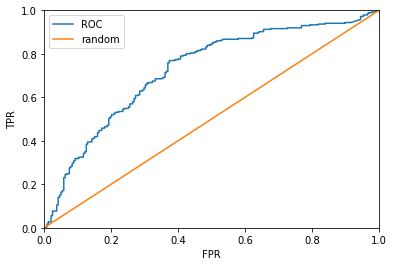

In [ ]:
# 1. 정확도
print(f"정확도 : {accuracy_score(y_test, svm_predict)}")

# 2. 오차 행렬
conf_matrix = confusion_matrix(y_true = y_test, y_pred = svm_predict) 
print(f"오차행렬 :\n{conf_matrix}")  ##  TN FP / FN TP

# 3. 정밀도와 재현율
print(f"정밀도 : {precision_score(y_test, svm_predict)}")
print(f"재현율 : {recall_score(y_test, svm_predict)}")

# 4. F1-score
print(f"F1-score : {f1_score(y_test, svm_predict)}")

# 5. ROC/AUC  
print(f"ROC score : {roc_auc_score(y_test, svm_predict)}")


# 그래프 =====================
import matplotlib.pyplot as plt

# 분류가 1인 친구들 모으기
pred_proba_class1 = svm_model.predict_proba(X_test)[:, 1]
fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)

# 시각화 시작
plt.plot(fprs, tprs, label='ROC')
plt.plot([0, 1], [0, 1], label = 'random')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

### 5-2. 결정트리

In [ ]:
decision_tree_model = DecisionTreeClassifier(max_depth=6)
decision_tree_model.fit(X_train, y_train)
decision_cross_val = cross_validate(estimator=decision_tree_model, X=X_train, y=y_train, cv=5)
print(f"예측 점수 : {decision_cross_val['test_score'].mean()}")

예측 점수 : 0.6757961783439491


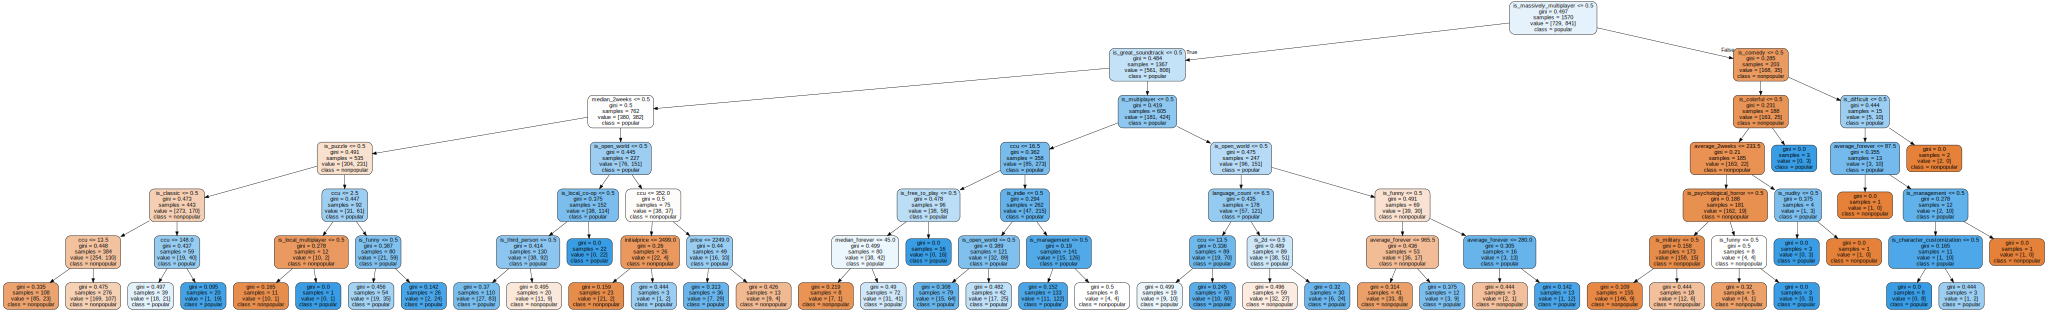

In [ ]:
dot_data = export_graphviz(decision_tree=decision_tree_model,
                           feature_names=X_train.keys(),
                           filled=True,
                           rounded=True,
                           class_names=["nonpopular", "popular"]
                           )
graph = graphviz.Source(dot_data)
graph

[Text(11081.408450704224, 1514.3142857142857, 'X[11] <= 0.5\ngini = 0.497\nsamples = 1570\nvalue = [729, 841]'),
 Text(6542.7464788732395, 1281.3428571428572, 'X[63] <= 0.5\ngini = 0.484\nsamples = 1367\nvalue = [561, 806]'),
 Text(3477.676056338028, 1048.3714285714286, 'X[4] <= 0.5\ngini = 0.5\nsamples = 762\nvalue = [380, 382]'),
 Text(1886.1971830985915, 815.4, 'X[13] <= 0.5\ngini = 0.491\nsamples = 535\nvalue = [304, 231]'),
 Text(943.0985915492957, 582.4285714285713, 'X[58] <= 0.5\ngini = 0.473\nsamples = 443\nvalue = [273, 170]'),
 Text(471.5492957746479, 349.4571428571428, 'X[8] <= 13.5\ngini = 0.448\nsamples = 384\nvalue = [254, 130]'),
 Text(235.77464788732394, 116.48571428571427, 'gini = 0.335\nsamples = 108\nvalue = [85, 23]'),
 Text(707.3239436619718, 116.48571428571427, 'gini = 0.475\nsamples = 276\nvalue = [169, 107]'),
 Text(1414.6478873239437, 349.4571428571428, 'X[8] <= 148.0\ngini = 0.437\nsamples = 59\nvalue = [19, 40]'),
 Text(1178.8732394366198, 116.48571428571427,

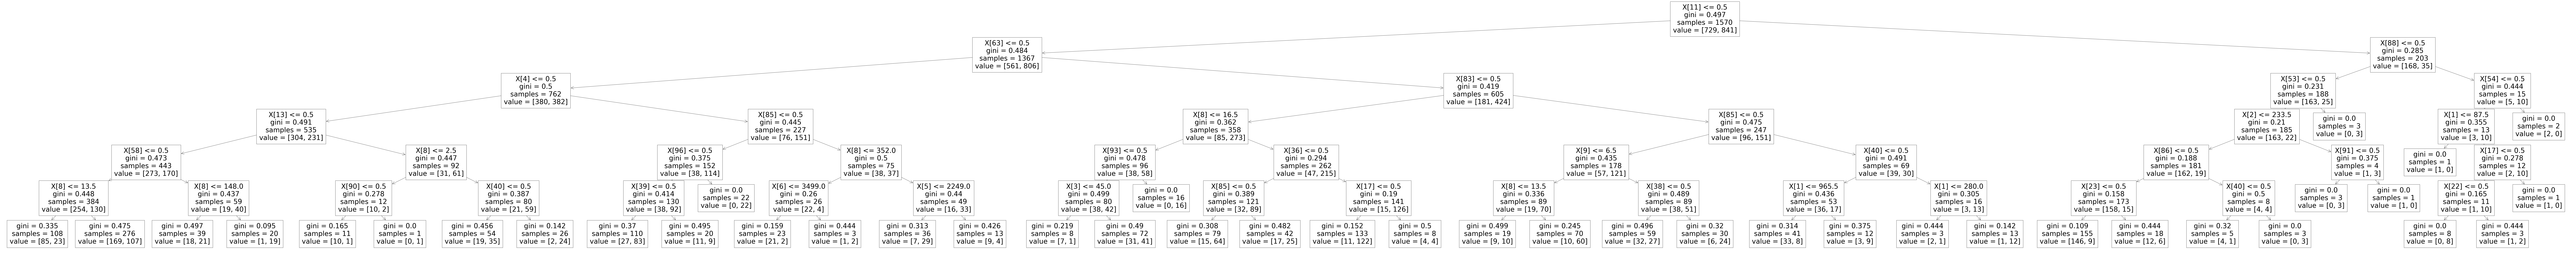

In [ ]:
# 간추린 형태
plt.figure(figsize=(300,30))
from sklearn import tree
tree.plot_tree(decision_tree_model)

### 5-3. Random Forest

In [ ]:
rf_model = RandomForestClassifier()
cross_val = cross_validate(estimator=rf_model, X=X_train, y=y_train, cv=5)
print(f"average test score :", cross_val['test_score'].mean())

average test score : 0.7171974522292993


In [ ]:
rf_model = ExtraTreesClassifier()
cross_val = cross_validate(estimator=rf_model, X=X_train, y=y_train, cv=5)
print(f"average test score :", cross_val['test_score'].mean())

average test score : 0.6980891719745224


### 5-4. 신경망 이용 학습

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
print(X_train.shape, y_train.shape)

(1570, 98) (1570,)


In [ ]:
layer_model = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='sigmoid', input_shape=(98,)),
    tf.keras.layers.Dense(units=16, activation='sigmoid'),
    tf.keras.layers.Dense(units=4, activation='sigmoid'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [ ]:
layer_model.compile(loss='binary_crossentropy')  # 이진 분류
layer_model.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_157 (Dense)            (None, 64)                6336      
_________________________________________________________________
dense_158 (Dense)            (None, 16)                1040      
_________________________________________________________________
dense_159 (Dense)            (None, 4)                 68        
_________________________________________________________________
dense_160 (Dense)            (None, 1)                 5         
Total params: 7,449
Trainable params: 7,449
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = layer_model.fit(X_train, y_train, epochs=500)

Epoch 1/500
50/50 [==============================] - 1s 992us/step - loss: 0.6951
Epoch 2/500
50/50 [==============================] - 0s 928us/step - loss: 0.6836
Epoch 3/500
50/50 [==============================] - 0s 949us/step - loss: 0.6798
Epoch 4/500
50/50 [==============================] - 0s 945us/step - loss: 0.6690
Epoch 5/500
50/50 [==============================] - 0s 955us/step - loss: 0.6686
Epoch 6/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6642
Epoch 7/500
50/50 [==============================] - 0s 936us/step - loss: 0.6543
Epoch 8/500
50/50 [==============================] - 0s 956us/step - loss: 0.6538
Epoch 9/500
50/50 [==============================] - 0s 952us/step - loss: 0.6572
Epoch 10/500
50/50 [==============================] - 0s 987us/step - loss: 0.6479
Epoch 11/500
50/50 [==============================] - 0s 976us/step - loss: 0.6491
Epoch 12/500
50/50 [==============================] - 0s 1ms/step - loss: 0.6529
Epoch 13/500
50/5

In [ ]:
layer_model.evaluate(X_test, y_test)

17/17 [==============================] - 0s 904us/step - loss: 0.7093


0.7092843651771545

In [ ]:
arr = layer_model.predict(X_test)
trans = [0 if val<0.5 else 1 for val in arr]
correct = (trans == y_test)
data = correct.value_counts()
true_cnt = data[1]
false_cnt = data[0]
print(f"적중률 : {true_cnt/(true_cnt+false_cnt)}")
print(data)

적중률 : 0.7137404580152672
True     374
False    150
dtype: int64
